## Explore SLP, Z500, SAT trends in observations, seasonally

In [14]:
# Much of this is taken from plot_coldeurasia_ts

import cccmautils as cutl

%matplotlib inline



# SET UP DATA
#timesel='1979-01-01,2015-07-01'
timesel='1979-01-01,2014-12-31'

obspath= '/Volumes/KellyDataDisk1/work/DATA/'
obspath2 = '/Volumes/KellyDataDisk1/work/BCs/'

graveraint= 9.80665 # m/s2 (different from Canadian models)

regions = {'EUR': 'eurasiamori',
           'BKS': 'bksmori',
           'GM': 'gm',
           'NH': 'nh',
           'EPAC': 'etroppac',
           'ARCTIC': 'gt60n'}

fnames={'sat': obspath + 'GISS/gistemp1200_ERSSTv4.nc',
           'sat2': obspath + 'ERAINT/td_era_int_197901_201507_gp_128_64_st_1979011612-2015071612.nc',
           'z500': obspath + 'ERAINT/td_era_int_197901_201507_gp_128_64_phi500_1979011612-2015071612.nc',
           'sic': obspath2 + 'NSIDC/td_bootstrap_197811_latest_128_64_sicn_1978111600-2013121612.nc',
           'slp': obspath + 'ERAINT/td_era_int_197901_latest_gp_128_64_pmsl.001_1979011612-2015121612.nc' }

# Use long reanalyses to compute Z500 / SAT correlation
regionslong={'EUR': 'eurasiamori',
             'BKS': 'bksmori',
             'GM': 'gm',
              'NH': 'nh'}
fnameslong={'sat': obspath + '20CR/air950.mon.mean.nc',
            'z500': obspath + '20CR/hgt500.mon.mean.nc'} # try air temp at 1000 hPa or 950 hPa?@@
timesellong='1900-01-01,2012-12-31'
fieldslong={'sat':'air',
           'z500': 'hgt'}


fields={'sat': 'tempanomaly',
        'sat2': 'ST',
        'z500': 'PHI',
        'sic': 'SICN',
        'slp': 'PMSL'}
convs = {'sat': 100, # GISStemp needs *100 b/c scale_factor is not working anymore in reading NC file. @@@
         'sat2': 1,
         'z500': 1/graveraint,
         'sic': 100,
         'slp': 1 }

In [2]:

def runmean(input, window=5,axis=0) :
    ret = np.cumsum(input, dtype=float,axis=axis)
    ret[window:,...] = ret[window:,...] - ret[:-window,...]
    return ret[window - 1:,...] / np.float(window)

def selectmonths(input,start=0, incr=3, weights=(0.34444444,0.34444444,0.31111111),
                 retavg=False):
    """ choose selected months but repeat until end of time dim (assume axis=0!!)
        This is for a monthly average dataset!
        
            retavg: a flag to specify whether the average of the chosen months
                    should be returned instead of the individual months
                    For example, if True, if selected months are D,J,F then 
                       timeseries of DJF means will be returned instead of D,J,F repeating
            weights are for D,J,F average into DJF seasonal mean
            
            returns either array of D,J,F OR array of DJF mean
            
    """
    nt = input.shape[0]
    #nyrs = nt/12
    # note that start is a zero-based index, whereas nt is a value starting at 1.
    rem = np.mod((nt-start),12)
    nyrs = (nt-start)/12
    print 'start,nyrs,remainder ' + str(start),str(nyrs),str(rem)
    if rem>=incr:
        nyrs=nyrs+1
        
    print 'nyrs ' + str(nyrs)
    
    ntout = nyrs*incr # leave off trailing months if they exist. @@@ works only if first idx is 0??
    
    #print type(input[0])
    
    if input.ndim>1:
        otherdims=input.shape[1:]
    else:
        #print 'selectmonths() on 1-D not tested @@@@'
        otherdims=()
        #return -1
    
    if 'datetime' in str(type(input[0])) :
        ret=[]
    else:
        if retavg:
            ret = np.zeros((nyrs,)+otherdims)
        else:
            ret = np.zeros((ntout,)+otherdims) #input.shape[1],input.shape[2]))

        print 'ret.shape ' + str(ret.shape)
    print 'nyrs ' + str(nyrs) + ', and ' + str(ntout/incr)
    
    for yridx in range(0,nyrs):
        subsamp = range(start+yridx*12,start+yridx*12+incr)
        #print yridx, subsamp # @@@
        if retavg:
            ret[yridx,...] = np.average(input[subsamp,...],weights=np.array(weights),axis=0)
        else:
            if 'datetime' in str(type(input[0])): # hack to check dates that are selected               
                ret[yridx*incr:yridx*incr+incr] = input[subsamp]
                
            else: # hack to check dates that are selected
                
                ret[yridx*incr:yridx*incr+incr,...] = input[subsamp,...]  
        
        #print 'input[subsamp,...].shape ' + str(input[subsamp,...].shape)

    return ret

def rem_monmean(input,incr=3):
    """
          Should handle 1D or >1D. Time must be first dimension!
          
          removes the climatological monthly mean from a timeseries that
              does not include all months. 
              
              incr: number of months per year in the timeseries
                    e.g. could be Dec_yr1,Jan_yr1,Feb_yr1,Dec_yr2,Jan_yr2,Feb_yr2 
                         so incr=3
                         
              returns a tuple: timeseries w/ climo removed, the tiled climo that was removed      
    """
    ntime = input.shape[0]
    nyr = ntime/incr
    print 'nyr ' + str(nyr)
    
    if input.ndim>1:
        otherdims=input.shape[1:]
        oshape = tuple(np.ones(len(otherdims)))
        tshape = (nyr,)+oshape # tile shape
        remclimo = np.zeros((incr,)+otherdims) # climatology to remove
        print 'remclimo.shape ' + str(remclimo.shape)
    else:
        tshape = (nyr,) # tile shape
        remclimo = np.zeros((incr)) # climatology to remove
        print 'remclimo.shape ' + str(remclimo.shape)
        
    # average each month separately
    for midx in range(0,incr):
        #print midx
        #print 'removing ' + str(np.mean(input[midx::incr,...],axis=0))
        remclimo[midx,...] = np.mean(input[midx::incr,...],axis=0)
        
    
    remclimot=np.tile(remclimo,tshape) # tile the climo for number of years
    print 'remclimot.shape ' + str(remclimot.shape)
    
    
    inrem = input - remclimot
    
    return inrem,remclimot

def detrend_monthly(input,incr=3):
    """
          Should handle 1D or >1D. Time must be first dimension!
          
          detrends on a monthly basis, when input is a timeseries that
              does not include all months. (It could, haven't tried)
              
              incr: number of months per year in the timeseries
                    e.g. could be Dec_yr1,Jan_yr1,Feb_yr1,Dec_yr2,Jan_yr2,Feb_yr2 
                         so incr=3
                         
              returns: detrended timeseries w/ shape the same as input
    """
    
    ntime = input.shape[0]
    nyr = ntime/incr
    print 'nyr ' + str(nyr)
    
    if input.ndim>1:
        otherdims=input.shape[1:]
        retdtr = np.zeros((ntime,)+otherdims) # detrended data
        print 'retdtr.shape ' + str(retdtr.shape)
    else:
        retdtr = np.zeros((ntime)) # detrended data
        #print 'retdtr.shape ' + str(retdtr.shape)
        
    # average each month separately
    for midx in range(0,incr):
        #print midx
        #print 'detrending ' + str(np.mean(input[midx::incr,...],axis=0))
        retdtr[midx::incr,...] = cutl.detrend(input[midx::incr,...],axis=0)
        #@@input[midx::incr,...] = cutl.detrend(input[midx::incr,...],axis=0)
        
    return retdtr

# calculate regressions w/ space
def corrmap(inr,insp,dims):
    """   
          inr is 1D [time or numens]
          insp is 2D [time or numens x space.flat]
          dims are a tuple of dims to reshape space to (nlat,nlon) 

          returns slopemap,corrmap,pvalmap [dims]           
    """ 
    #print inr.shape, insp.shape
    
    mm,bb,rval,pval = cutl.regress(inr,insp)
    #slope,intercept = np.polyfit(inr,insp, 1)
    corrmap = rval.reshape(dims)
    pvmap = pval.reshape(dims)
    slopemap = mm.reshape(dims)
    
    return slopemap,corrmap,pvmap


In [15]:
import constants as con
con=reload(con)

# LOAD DATA
sea='DJF'

flddt={}; fldregdt={}; latdt={}; londt={}; xxdt={}
for fkey in fnames.keys():
    fname = fnames[fkey]
    conv = convs[fkey]
    print fname, fields[fkey], conv
    alsomask=None
    if fkey=='sic':
        alsomask='land'
        
    fld = cnc.getNCvar(fname,fields[fkey],timesel=timesel,seas=sea)*conv 
    latdt[fkey] = cnc.getNCvar(fname,'lat')
    londt[fkey] = cnc.getNCvar(fname,'lon')

    flddt[fkey] = fld

    regdt={}
    for regkey in regions.keys():
        print regkey
        regdt[regkey] = cutl.calc_regmean(fld,latdt[fkey],londt[fkey],
                                          regions[regkey],model=None,alsomask=alsomask)

    xxdt[fkey] = np.arange(0,len(regdt[regkey])) # length of last reg good for all reg in field
    fldregdt[fkey] = regdt

# load 3D SAT for obs:
fldspdt={}
fldspdt['sat'] = cnc.getNCvar(fname,fields['sat'],timesel=timesel,seas=sea)*conv 

    
# DO ANN too
fldanndt={}; fldannregdt={}; xxanndt={}
for fkey in fnames.keys():
    fname = fnames[fkey]
    conv = convs[fkey]
    print fname, fields[fkey], conv
    alsomask=None
    if fkey=='sic':
        alsomask='land'
        
    fld = cnc.getNCvar(fname,fields[fkey],timesel=timesel,seas='ANN')*conv 

    fldanndt[fkey] = fld

    reganndt={}
    for regkey in regions.keys():
        reganndt[regkey] = cutl.calc_regmean(fld,latdt[fkey],londt[fkey],
                                             regions[regkey],model=None,alsomask=alsomask)

    xxanndt[fkey] = np.arange(0,len(reganndt[regkey])) # length of last reg good for all reg in field
    fldannregdt[fkey] = reganndt

    
# and JJA
fldjjadt={}; fldjjaregdt={}; xxjjadt={}
for fkey in fnames.keys():
    fname = fnames[fkey]
    conv = convs[fkey]
    print fname, fields[fkey], conv
    alsomask=None
    if fkey=='sic':
        alsomask='land'
        
    fld = cnc.getNCvar(fname,fields[fkey],timesel=timesel,seas='JJA')*conv 

    fldjjadt[fkey] = fld

    regjjadt={}
    for regkey in regions.keys():
        regjjadt[regkey] = cutl.calc_regmean(fld,latdt[fkey],londt[fkey],
                                             regions[regkey],model=None,alsomask=alsomask)

    xxjjadt[fkey] = np.arange(0,len(regjjadt[regkey])) # length of last reg good for all reg in field
    fldjjaregdt[fkey] = regjjadt
    
# and SON
fldsondt={}; fldsonregdt={}; xxsondt={}
for fkey in fnames.keys():
    fname = fnames[fkey]
    conv = convs[fkey]
    print fname, fields[fkey], conv
    alsomask=None
    if fkey=='sic':
        alsomask='land'
        
    fld = cnc.getNCvar(fname,fields[fkey],timesel=timesel,seas='SON')*conv 

    fldsondt[fkey] = fld

    regsondt={}
    for regkey in regions.keys():
        regsondt[regkey] = cutl.calc_regmean(fld,latdt[fkey],londt[fkey],
                                             regions[regkey],model=None,alsomask=alsomask)

    xxsondt[fkey] = np.arange(0,len(regsondt[regkey])) # length of last reg good for all reg in field
    fldsonregdt[fkey] = regsondt


/Volumes/KellyDataDisk1/work/BCs/NSIDC/td_bootstrap_197811_latest_128_64_sicn_1978111600-2013121612.nc SICN 100
NH
calc_regmean() removing extra lon. fld new shape: (34, 64, 128)
ARCTIC
calc_regmean() removing extra lon. fld new shape: (34, 64, 128)
EPAC
calc_regmean() removing extra lon. fld new shape: (34, 64, 128)
BKS
calc_regmean() removing extra lon. fld new shape: (34, 64, 128)
GM
calc_regmean() removing extra lon. fld new shape: (34, 64, 128)
Global average!
EUR
calc_regmean() removing extra lon. fld new shape: (34, 64, 128)
/Volumes/KellyDataDisk1/work/DATA/ERAINT/td_era_int_197901_201507_gp_128_64_st_1979011612-2015071612.nc ST 1
NH
calc_regmean() removing extra lon. fld new shape: (35, 64, 128)
ARCTIC
calc_regmean() removing extra lon. fld new shape: (35, 64, 128)
EPAC
calc_regmean() removing extra lon. fld new shape: (35, 64, 128)
BKS
calc_regmean() removing extra lon. fld new shape: (35, 64, 128)
GM
calc_regmean() removing extra lon. fld new shape: (35, 64, 128)
Global aver

['sic', 'sat2', 'sat', 'slp', 'z500']
(36, 64, 129)
['sic', 'sat2', 'sat', 'slp', 'z500']
['NH', 'ARCTIC', 'EPAC', 'BKS', 'GM', 'EUR']


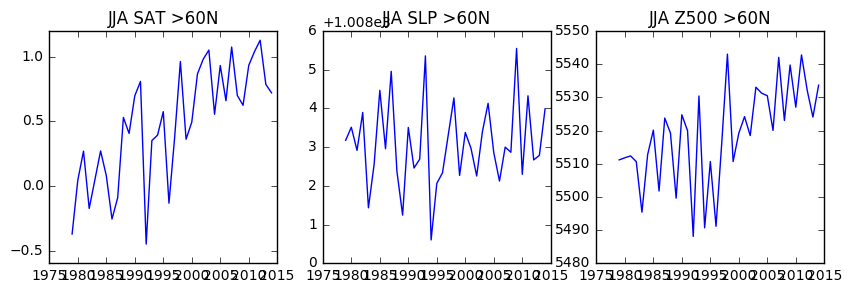

In [22]:
startyr = 1979

print fldjjadt.keys()
print fldjjadt['slp'].shape

print fldjjaregdt.keys()
print fldjjaregdt['slp'].keys()




fig,axs=plt.subplots(1,3,figsize=(10,3))

xx=xxjjadt['sat']+startyr
ax=axs[0]
ax.plot(xx,fldjjaregdt['sat']['ARCTIC'])
ax.set_title('JJA SAT >60N')

xx=xxjjadt['slp']+startyr
ax=axs[1]
ax.plot(xx,fldjjaregdt['slp']['ARCTIC'])
ax.set_title('JJA SLP >60N')

xx=xxjjadt['z500']+startyr
ax=axs[2]
ax.plot(xx,fldjjaregdt['z500']['ARCTIC'])
ax.set_title('JJA Z500 >60N')


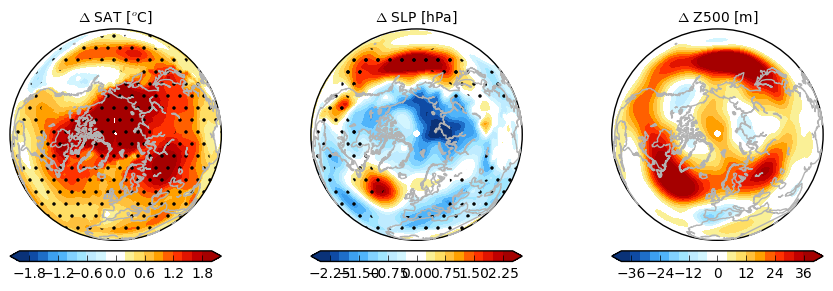

In [41]:
printtofile=True

plotsea='SON'

# (2003-2012) - (1979-1988)
if plotsea=='JJA':
    slpanom = fldjjadt['slp'][-12:-2,...].mean(axis=0) - fldjjadt['slp'][:10,...].mean(axis=0)
    satanom = fldjjadt['sat'][-12:-2,...].mean(axis=0) - fldjjadt['sat'][:10,...].mean(axis=0)
    z500anom = fldjjadt['z500'][-12:-2,...].mean(axis=0) - fldjjadt['z500'][:10,...].mean(axis=0)

    _,satpvals = cutl.ttest_ind(fldjjadt['sat'][-12:-2,...], fldjjadt['sat'][:10,...],axis=0)
    _,slppvals = cutl.ttest_ind(fldjjadt['slp'][-12:-2,...], fldjjadt['slp'][:10,...],axis=0)
    _,z500pvals = cutl.ttest_ind(fldjjadt['z500'][-12:-2,...], fldjjadt['z500'][:10,...],axis=0)
elif plotsea=='DJF':
    slpanom = flddt['slp'][-11:-1,...].mean(axis=0) - flddt['slp'][:10,...].mean(axis=0)
    satanom = flddt['sat'][-11:-1,...].mean(axis=0) - flddt['sat'][:10,...].mean(axis=0)
    z500anom = flddt['z500'][-11:-1,...].mean(axis=0) - flddt['z500'][:10,...].mean(axis=0)

    _,satpvals = cutl.ttest_ind(flddt['sat'][-11:-1,...], flddt['sat'][:10,...],axis=0)
    _,slppvals = cutl.ttest_ind(flddt['slp'][-11:-1,...], flddt['slp'][:10,...],axis=0)
    _,z500pvals = cutl.ttest_ind(flddt['z500'][-11:-1,...], flddt['z500'][:10,...],axis=0)
elif plotsea=='SON':
    slpanom = fldsondt['slp'][-11:-1,...].mean(axis=0) - fldsondt['slp'][:10,...].mean(axis=0)
    satanom = fldsondt['sat'][-11:-1,...].mean(axis=0) - fldsondt['sat'][:10,...].mean(axis=0)
    z500anom = fldsondt['z500'][-11:-1,...].mean(axis=0) - fldsondt['z500'][:10,...].mean(axis=0)

    _,satpvals = cutl.ttest_ind(fldsondt['sat'][-11:-1,...], fldsondt['sat'][:10,...],axis=0)
    _,slppvals = cutl.ttest_ind(fldsondt['slp'][-11:-1,...], fldsondt['slp'][:10,...],axis=0)
    _,z500pvals = cutl.ttest_ind(fldsondt['z500'][-11:-1,...], fldsondt['z500'][:10,...],axis=0)
    
    
    
fig,axs=plt.subplots(1,3,figsize=(11,3))
ax=axs[0]
bm,pc = cplt.kemmap(satanom,latdt['sat'],londt['sat'],axis=ax,ptype='nh',
                 cmin=-2,cmax=2,title='$\Delta$ SAT [$^o$C]')
cplt.addtsigm(bm,satpvals,latdt['sat'],londt['sat'],sigtype='hatch')

ax=axs[1]
bm,pc = cplt.kemmap(slpanom,latdt['slp'],londt['slp'],axis=ax,ptype='nh',
                 cmin=-2.5,cmax=2.5,title='$\Delta$ SLP [hPa]')
cplt.addtsigm(bm,slppvals,latdt['slp'],londt['slp'],sigtype='hatch')

ax=axs[2]
ret = cplt.kemmap(z500anom,latdt['z500'],londt['z500'],axis=ax,ptype='nh',
                 cmin=-40,cmax=40,title='$\Delta$ Z500 [m]')
cplt.addtsigm(bm,z500pvals,latdt['z500'],londt['z500'],sigtype='hatch')

if printtofile:
    fig.savefig('Observedchanges_' + plotsea + '_1979-89to2002-12_SAT_SLP_Z500.pdf')